In [14]:
import logging
import os
import time
import requests

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler

In [32]:
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 3600 # Time in seconds for automl run
TARGET_NAME = 'Is_Lead' # Target column name

In [16]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [17]:
data = pd.read_csv('smotetrain.csv')
#data.drop(["ID"],inplace=True,axis=1)
data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,0.0,73.0,18.0,1.0,2.0,43.0,0.0,1045696.0,0.0,0
1,0.0,30.0,27.0,2.0,0.0,32.0,0.0,581988.0,0.0,0
2,0.0,56.0,18.0,3.0,2.0,26.0,0.0,1484315.0,1.0,0
3,1.0,34.0,20.0,2.0,0.0,19.0,0.0,470454.0,0.0,0
4,0.0,30.0,32.0,2.0,0.0,33.0,0.0,886787.0,0.0,0


In [18]:
train_data, test_data = train_test_split(data, 
                                         test_size=TEST_SIZE, 
                                         stratify=data[TARGET_NAME], 
                                         random_state=RANDOM_STATE)
logging.info('Data splitted. Parts sizes: train_data = {}, test_data = {}'
              .format(train_data.shape, test_data.shape))

INFO:root:Data splitted. Parts sizes: train_data = (299899, 10), test_data = (74975, 10)


In [19]:
task = Task('binary', )
roles = {'target': TARGET_NAME,
         DatetimeRole(base_date=True, seasonality=(), base_feats=False): 'report_dt',
         }

In [ ]:
automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))


Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start automl preset with listed constraints:
- time: 620 seconds
- cpus: 8 cores
- memory: 16 gb

Train data shape: (299899, 10)


LightAutoML used 9 feats
1/9 Calculated score for Gender: 0.0000671
2/9 Calculated score for Channel_Code: 0.0075381
3/9 Calculated score for Credit_Product: 0.2096989
4/9 Calculated score for Avg_Account_Balance: 0.0001893
5/9 Calculated score for Occupation: 0.0802830
6/9 Calculated score for Region_Code: 0.0010754
7/9 Calculated score for Vintage: 0.0372890
8/9 Calculated score for Is_Active: 0.0049491
9/9 Calculated score for Age: 0.0567152


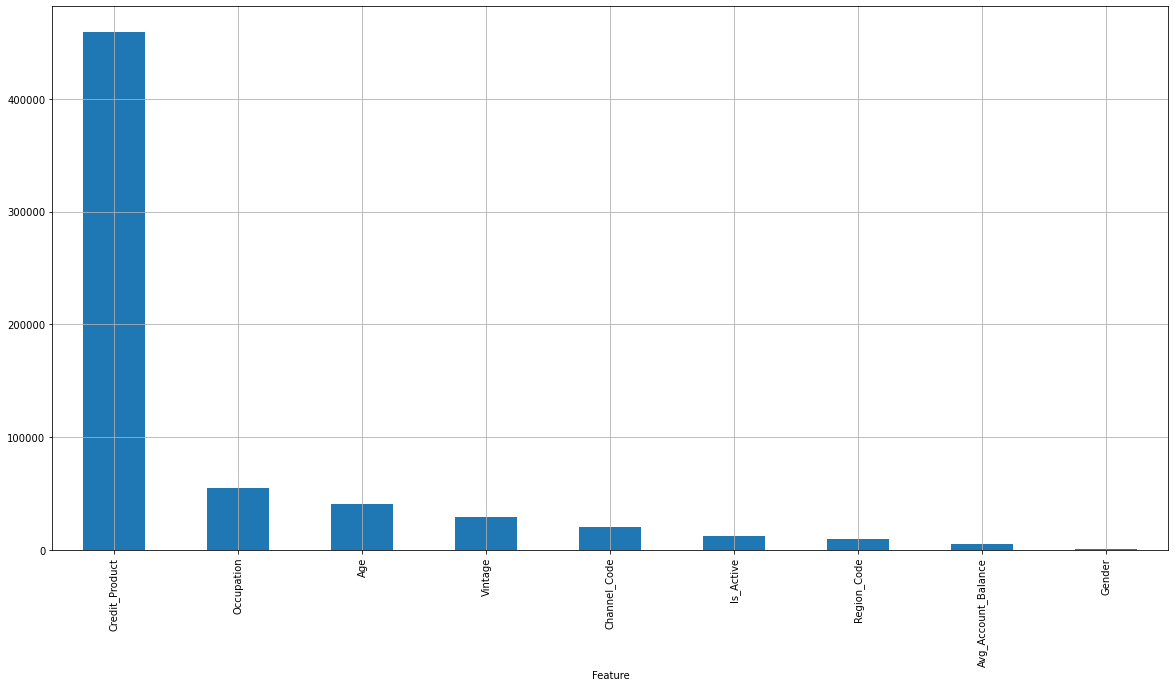

In [8]:
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)
accurate_fi = automl.get_feature_scores('accurate', test_data, silent = False)
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

In [9]:
test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

logging.info('Check scores...')
#logging.info('OOF score: {}'.format(roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))
#logging.info('TEST score: {}'.format(roc_auc_score(test_data[TARGET_NAME].values, test_pred.data[:, 0])))

[2021-05-30 23:15:40,471] (INFO): Prediction for test data:
array([[0.05085582],
       [0.09890639],
       [0.9858508 ],
       ...,
       [0.05335942],
       [0.03970084],
       [0.1885561 ]], dtype=float32)
Shape = (49145, 1)
[2021-05-30 23:15:40,472] (INFO): Check scores...


In [ ]:
automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 8, 'cv': 5, 'random_state': 42}
Start automl preset with listed constraints:
- time: 3599.9970405101776 seconds
- cpus: 8 cores
- memory: 16 gb

Train data shape: (299899, 10)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 3529.4948194026947 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8943937575724086
Linear model: C = 5e-05 score = 0.9004349905008905
Linear model: C = 0.0001 score = 0.904350328068676
Linear model: C = 0.0005 score = 0.9163458370751794
Linear model: C = 0.001 score = 0.9190392040205466
Linear model: C = 0.005 score = 0.9229836671132235
Linear model: C = 0.01 score = 0.923936643435997
Linear model: C = 0.0

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-71d16347-c076-4365-96fc-112ffa058ea7


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.933298
[200]	valid's auc: 0.933633
[300]	valid's auc: 0.933597
Early stopping, best iteration is:
[249]	valid's auc: 0.933682
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 0 finished with value: 0.9336822794438204 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: 0.9336822794438204.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.933477
[200]	valid's auc: 0.933963
[300]	valid's auc: 0.933943
[400]	valid's auc: 0.933904
Early stopping, best iteration is:
[317]	valid's auc: 0.933989
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 1 finished with value: 0.9339887943085619 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 1 with value: 0.9339887943085619.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.932739
[200]	valid's auc: 0.933537
[300]	valid's auc: 0.933583
Early stopping, best iteration is:
[226]	valid's auc: 0.933644
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 2 finished with value: 0.9336442507622581 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 0.9339887943085619.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.933229
[200]	valid's auc: 0.933512
[300]	valid's auc: 0.933613
[400]	valid's auc: 0.933635
[500]	valid's auc: 0.933663
Early stopping, best iteration is:
[495]	valid's auc: 0.93367
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 3 finished with value: 0.9336701296786603 and parameters: {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05}. Best is trial 1 with value: 0.9339887943085619.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.933011
[200]	valid's auc: 0.933172
Early stopping, best iteration is:
[145]	valid's auc: 0.933292
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 4 finished with value: 0.9332920988111965 and parameters: {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08}. Best is trial 1 with value: 0.9339887943085619.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.932781
[200]	valid's auc: 0.933429
[300]	valid's auc: 0.93364
[400]	valid's auc: 0.933649
[500]	valid's auc: 0.933731
Early stopping, best iteration is:
[487]	valid's auc: 0.933765
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 5 finished with value: 0.9337646482360853 and parameters: {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 1 with value: 0.9339887943085619.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.93284
[200]	valid's auc: 0.933478
[300]	valid's auc: 0.933704
[400]	valid's auc: 0.933774
Early stopping, best iteration is:
[377]	valid's auc: 0.933795
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 6 finished with value: 0.933794824461327 and parameters: {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574}. Best is trial 1 with value: 0.9339887943085619.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.932868
[200]	valid's auc: 0.933058
[300]	valid's auc: 0.93298
Early stopping, best iteration is:
[254]	valid's auc: 0.933162
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 7 finished with value: 0.9331619687389405 and parameters: {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129}. Best is trial 1 with value: 0.9339887943085619.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.932984
[200]	valid's auc: 0.93375
[300]	valid's auc: 0.933883
[400]	valid's auc: 0.93392
[500]	valid's auc: 0.934015
[600]	valid's auc: 0.93404
[700]	valid's auc: 0.934088
[800]	valid's auc: 0.934124
Early stopping, best iteration is:
[798]	valid's auc: 0.934129
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 8 finished with value: 0.9341290817067954 and parameters: {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 8 with value: 0.9341290817067954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.93288
[200]	valid's auc: 0.933148
Early stopping, best iteration is:
[178]	valid's auc: 0.933176
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 9 finished with value: 0.933176150414037 and parameters: {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06}. Best is trial 8 with value: 0.9341290817067954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.932917
[200]	valid's auc: 0.933573
[300]	valid's auc: 0.933687
[400]	valid's auc: 0.933692
Early stopping, best iteration is:
[338]	valid's auc: 0.933715
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 10 finished with value: 0.933714645462014 and parameters: {'feature_fraction': 0.9725682721151934, 'num_leaves': 134, 'bagging_fraction': 0.9847685553939332, 'min_sum_hessian_in_leaf': 5.997863556602819, 'reg_alpha': 7.159256876318388, 'reg_lambda': 0.16588182839130192}. Best is trial 8 with value: 0.9341290817067954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.933227
[200]	valid's auc: 0.933874
[300]	valid's auc: 0.933896
[400]	valid's auc: 0.933909
Early stopping, best iteration is:
[373]	valid's auc: 0.933939
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 11 finished with value: 0.9339391495509062 and parameters: {'feature_fraction': 0.5077973998292281, 'num_leaves': 166, 'bagging_fraction': 0.9961813327301685, 'min_sum_hessian_in_leaf': 1.107899668292902, 'reg_alpha': 0.014725306700494503, 'reg_lambda': 7.3871412375861425}. Best is trial 8 with value: 0.9341290817067954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.933075
[200]	valid's auc: 0.933574
[300]	valid's auc: 0.933749
[400]	valid's auc: 0.933728
Early stopping, best iteration is:
[334]	valid's auc: 0.933776
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 12 finished with value: 0.9337761581302916 and parameters: {'feature_fraction': 0.5945472039245955, 'num_leaves': 113, 'bagging_fraction': 0.71105092313619, 'min_sum_hessian_in_leaf': 1.1357685978206988, 'reg_alpha': 0.15998888489412647, 'reg_lambda': 2.4368943076873095}. Best is trial 8 with value: 0.9341290817067954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931725
[200]	valid's auc: 0.932909
[300]	valid's auc: 0.933183
[400]	valid's auc: 0.933352
[500]	valid's auc: 0.933511
[600]	valid's auc: 0.933602
[700]	valid's auc: 0.933719
[800]	valid's auc: 0.933817
[900]	valid's auc: 0.933901
Early stopping, best iteration is:
[875]	valid's auc: 0.93392
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 13 finished with value: 0.9339199217344984 and parameters: {'feature_fraction': 0.8817118079813759, 'num_leaves': 17, 'bagging_fraction': 0.9131807318142184, 'min_sum_hessian_in_leaf': 1.9669755134523759, 'reg_alpha': 0.00015032920516722508, 'reg_lambda': 0.11731046101260606}. Best is trial 8 with value: 0.9341290817067954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.933181
[200]	valid's auc: 0.933647
[300]	valid's auc: 0.933818
[400]	valid's auc: 0.933664
Early stopping, best iteration is:
[326]	valid's auc: 0.9339
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 14 finished with value: 0.9338995131310304 and parameters: {'feature_fraction': 0.5982402802070008, 'num_leaves': 188, 'bagging_fraction': 0.7238774295032728, 'min_sum_hessian_in_leaf': 0.034726201518616565, 'reg_alpha': 0.23866132788588826, 'reg_lambda': 6.684907419672024}. Best is trial 8 with value: 0.9341290817067954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.933181
[200]	valid's auc: 0.93374
[300]	valid's auc: 0.933785
[400]	valid's auc: 0.93395
[500]	valid's auc: 0.934051
[600]	valid's auc: 0.933967
Early stopping, best iteration is:
[545]	valid's auc: 0.934062
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 15 finished with value: 0.9340620648140912 and parameters: {'feature_fraction': 0.8252288756597426, 'num_leaves': 100, 'bagging_fraction': 0.9328856998984195, 'min_sum_hessian_in_leaf': 2.906742716998493, 'reg_alpha': 8.673726994905894e-05, 'reg_lambda': 0.015382508042333834}. Best is trial 8 with value: 0.9341290817067954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.933146
[200]	valid's auc: 0.933753
[300]	valid's auc: 0.933936
[400]	valid's auc: 0.93395
Early stopping, best iteration is:
[337]	valid's auc: 0.934017
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 16 finished with value: 0.934016838001241 and parameters: {'feature_fraction': 0.8182550698311287, 'num_leaves': 105, 'bagging_fraction': 0.9399063224431738, 'min_sum_hessian_in_leaf': 9.403319551199754, 'reg_alpha': 0.00019949970708564203, 'reg_lambda': 0.012182416818763602}. Best is trial 8 with value: 0.9341290817067954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931661
[200]	valid's auc: 0.932844
[300]	valid's auc: 0.933141
[400]	valid's auc: 0.933332
[500]	valid's auc: 0.933517
[600]	valid's auc: 0.933605
[700]	valid's auc: 0.933648
[800]	valid's auc: 0.933705
[900]	valid's auc: 0.93377
[1000]	valid's auc: 0.933785
Early stopping, best iteration is:
[934]	valid's auc: 0.933803
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 17 finished with value: 0.933802713608771 and parameters: {'feature_fraction': 0.8607093776672629, 'num_leaves': 16, 'bagging_fraction': 0.9352837665178367, 'min_sum_hessian_in_leaf': 2.8288040082093486, 'reg_alpha': 0.0036977137267788928, 'reg_lambda': 0.023160626719843654}. Best is trial 8 with value: 0.9341290817067954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.933042
[200]	valid's auc: 0.933509
[300]	valid's auc: 0.933549
[400]	valid's auc: 0.933614
[500]	valid's auc: 0.933695
[600]	valid's auc: 0.933616
Early stopping, best iteration is:
[509]	valid's auc: 0.933729
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 18 finished with value: 0.9337294130832319 and parameters: {'feature_fraction': 0.9649553879622852, 'num_leaves': 88, 'bagging_fraction': 0.9683168501234709, 'min_sum_hessian_in_leaf': 2.542337931817775, 'reg_alpha': 3.3813370668465495e-05, 'reg_lambda': 0.005808008005273329}. Best is trial 8 with value: 0.9341290817067954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.933243
[200]	valid's auc: 0.93377
[300]	valid's auc: 0.933894
Early stopping, best iteration is:
[290]	valid's auc: 0.933914
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 19 finished with value: 0.9339142990978098 and parameters: {'feature_fraction': 0.7899019527608279, 'num_leaves': 144, 'bagging_fraction': 0.9036160582635028, 'min_sum_hessian_in_leaf': 0.191137067798127, 'reg_alpha': 0.8644403270079946, 'reg_lambda': 0.5099935913014406}. Best is trial 8 with value: 0.9341290817067954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.932778
[200]	valid's auc: 0.93347
[300]	valid's auc: 0.933645
[400]	valid's auc: 0.933748
[500]	valid's auc: 0.93377
[600]	valid's auc: 0.933848
[700]	valid's auc: 0.933913
[800]	valid's auc: 0.93392
Early stopping, best iteration is:
[751]	valid's auc: 0.933965
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 20 finished with value: 0.9339645853941978 and parameters: {'feature_fraction': 0.8753635542101719, 'num_leaves': 46, 'bagging_fraction': 0.9970023275843807, 'min_sum_hessian_in_leaf': 0.03450840993868498, 'reg_alpha': 0.02357823818259026, 'reg_lambda': 0.9024935250579662}. Best is trial 8 with value: 0.9341290817067954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.933176
[200]	valid's auc: 0.933747
[300]	valid's auc: 0.933928
[400]	valid's auc: 0.933984
[500]	valid's auc: 0.934016
[600]	valid's auc: 0.933976
Early stopping, best iteration is:
[553]	valid's auc: 0.934037
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 21 finished with value: 0.9340372093576597 and parameters: {'feature_fraction': 0.7698618503524449, 'num_leaves': 100, 'bagging_fraction': 0.9406732183853934, 'min_sum_hessian_in_leaf': 9.824074302574049, 'reg_alpha': 0.00034541959128253874, 'reg_lambda': 0.005153148804988277}. Best is trial 8 with value: 0.9341290817067954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.933374
[200]	valid's auc: 0.933818
[300]	valid's auc: 0.93396
[400]	valid's auc: 0.934013
[500]	valid's auc: 0.934037
[600]	valid's auc: 0.933998
Early stopping, best iteration is:
[521]	valid's auc: 0.934058

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.933123
[200]	valid's auc: 0.933489
[300]	valid's auc: 0.93364
[400]	valid's auc: 0.933718
[500]	valid's auc: 0.933682
Early stopping, best iteration is:
[467]	valid's auc: 0.933742

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.932801
[200]	valid's auc: 0.933239
[300]	valid's auc: 0.933357
[400]	valid's auc: 0.933467
[500]	va

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-c77d33b2-32ab-4239-b13e-654f4b4ee245


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.9117982	best: 0.9117982 (0)	total: 35.1ms	remaining: 1m 10s
100:	test: 0.9293515	best: 0.9293515 (100)	total: 4.05s	remaining: 1m 16s
200:	test: 0.9308991	best: 0.9308991 (200)	total: 7.69s	remaining: 1m 8s
300:	test: 0.9316393	best: 0.9316393 (300)	total: 11.4s	remaining: 1m 4s
400:	test: 0.9320794	best: 0.9320817 (399)	total: 15.1s	remaining: 1m
500:	test: 0.9324069	best: 0.9324069 (500)	total: 18.9s	remaining: 56.5s
600:	test: 0.9326990	best: 0.9326990 (600)	total: 22.6s	remaining: 52.6s
700:	test: 0.9328648	best: 0.9328648 (700)	total: 26.3s	remaining: 48.8s
800:	test: 0.9330189	best: 0.9330237 (795)	total: 30.1s	remaining: 45.1s
900:	test: 0.9331503	best: 0.9331511 (899)	total: 33.9s	remaining: 41.3s
1000:	test: 0.9332776	best: 0.9332779 (998)	total: 37.5s	remaining: 37.4s
1100:	test: 0.9333485	best: 0.9333486 (1092)	total: 41.2s	remaining: 33.6s
1200:	t

INFO:optuna.study:Trial 0 finished with value: 0.93371337517085 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.93371337517085.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.9158174	best: 0.9158174 (0)	total: 36.4ms	remaining: 1m 12s
100:	test: 0.9302987	best: 0.9302987 (100)	total: 4.29s	remaining: 1m 20s
200:	test: 0.9316083	best: 0.9316083 (200)	total: 8.06s	remaining: 1m 12s
300:	test: 0.9322411	best: 0.9322426 (299)	total: 11.9s	remaining: 1m 7s
400:	test: 0.9327233	best: 0.9327233 (400)	total: 15.8s	remaining: 1m 2s
500:	test: 0.9330040	best: 0.9330040 (500)	total: 19.5s	remaining: 58.4s
600:	test: 0.9331434	best: 0.9331474 (598)	total: 23.4s	remaining: 54.5s
700:	test: 0.9327300	best: 0.9332299 (656)	total: 27.3s	remaining: 50.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.933229884
bestIteration = 656

Shrink model to first 657 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


INFO:optuna.study:Trial 1 finished with value: 0.9332298845641668 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.93371337517085.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.9072753	best: 0.9072753 (0)	total: 29.1ms	remaining: 58.2s
100:	test: 0.9279361	best: 0.9279361 (100)	total: 3.65s	remaining: 1m 8s
200:	test: 0.9297446	best: 0.9297446 (200)	total: 7.11s	remaining: 1m 3s
300:	test: 0.9305330	best: 0.9305330 (300)	total: 10.6s	remaining: 1m
400:	test: 0.9310557	best: 0.9310570 (399)	total: 13.9s	remaining: 55.2s
500:	test: 0.9314071	best: 0.9314071 (500)	total: 17.1s	remaining: 51.1s
600:	test: 0.9316696	best: 0.9316696 (600)	total: 20.3s	remaining: 47.3s
700:	test: 0.9319570	best: 0.9319570 (700)	total: 23.5s	remaining: 43.5s
800:	test: 0.9321776	best: 0.9321776 (800)	total: 26.6s	remaining: 39.9s
900:	test: 0.9323429	best: 0.9323429 (900)	total: 29.8s	remaining: 36.3s
1000:	test: 0.9325026	best: 0.9325026 (1000)	total: 33s	remaining: 32.9s
1100:	test: 0.9326488	best: 0.9326497 (1099)	total: 36.3s	remaining: 29.7s
1200:	test

INFO:optuna.study:Trial 2 finished with value: 0.9332612827150009 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 13}. Best is trial 0 with value: 0.93371337517085.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.9191632	best: 0.9191632 (0)	total: 40.1ms	remaining: 1m 20s
100:	test: 0.9289804	best: 0.9309955 (99)	total: 5.02s	remaining: 1m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9309955125
bestIteration = 99

Shrink model to first 100 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


INFO:optuna.study:Trial 3 finished with value: 0.9309955130091713 and parameters: {'max_depth': 6, 'l2_leaf_reg': 1.5320059381854043e-08, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.93371337517085.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.9191574	best: 0.9191574 (0)	total: 53.9ms	remaining: 1m 47s
100:	test: 0.9314533	best: 0.9314533 (100)	total: 4.99s	remaining: 1m 33s
200:	test: 0.9323427	best: 0.9323516 (199)	total: 9.69s	remaining: 1m 26s
300:	test: 0.9326065	best: 0.9326065 (300)	total: 14.5s	remaining: 1m 21s
400:	test: 0.9327119	best: 0.9327157 (395)	total: 19.4s	remaining: 1m 17s
500:	test: 0.9328456	best: 0.9328647 (475)	total: 24.4s	remaining: 1m 12s
600:	test: 0.9329537	best: 0.9329580 (598)	total: 30s	remaining: 1m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9329579639
bestIteration = 598

Shrink model to first 599 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


INFO:optuna.study:Trial 4 finished with value: 0.9329579644253987 and parameters: {'max_depth': 7, 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.93371337517085.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.9072753	best: 0.9072753 (0)	total: 88.8ms	remaining: 2m 57s
100:	test: 0.9281228	best: 0.9281228 (100)	total: 3.85s	remaining: 1m 12s
200:	test: 0.9297906	best: 0.9297906 (200)	total: 7.14s	remaining: 1m 3s
300:	test: 0.9306455	best: 0.9306455 (300)	total: 10.3s	remaining: 58.4s
400:	test: 0.9311983	best: 0.9311994 (399)	total: 13.7s	remaining: 54.4s
500:	test: 0.9315647	best: 0.9315647 (500)	total: 16.9s	remaining: 50.6s
600:	test: 0.9318698	best: 0.9318698 (600)	total: 20.1s	remaining: 46.7s
700:	test: 0.9321064	best: 0.9321072 (698)	total: 23.2s	remaining: 43s
800:	test: 0.9323528	best: 0.9323528 (800)	total: 26.4s	remaining: 39.5s
900:	test: 0.9324772	best: 0.9324772 (900)	total: 29.5s	remaining: 36s
1000:	test: 0.9326253	best: 0.9326253 (1000)	total: 32.7s	remaining: 32.6s
1100:	test: 0.9327539	best: 0.9327539 (1100)	total: 35.8s	remaining: 29.2s
1200:	t

INFO:optuna.study:Trial 5 finished with value: 0.9333329877326009 and parameters: {'max_depth': 3, 'l2_leaf_reg': 5.472429642032198e-06, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.93371337517085.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.9158174	best: 0.9158174 (0)	total: 101ms	remaining: 3m 21s
100:	test: 0.9302846	best: 0.9302846 (100)	total: 4.39s	remaining: 1m 22s
200:	test: 0.9315339	best: 0.9315339 (200)	total: 8.28s	remaining: 1m 14s
300:	test: 0.9321290	best: 0.9321290 (300)	total: 12.2s	remaining: 1m 8s
400:	test: 0.9325512	best: 0.9325512 (400)	total: 16.1s	remaining: 1m 4s
500:	test: 0.9328694	best: 0.9328694 (500)	total: 20s	remaining: 59.8s
600:	test: 0.9330831	best: 0.9330831 (600)	total: 23.9s	remaining: 55.6s
700:	test: 0.9331761	best: 0.9332403 (684)	total: 27.7s	remaining: 51.3s
800:	test: 0.9332842	best: 0.9332842 (800)	total: 31.6s	remaining: 47.3s
900:	test: 0.9333719	best: 0.9333719 (900)	total: 35.8s	remaining: 43.6s
1000:	test: 0.9333808	best: 0.9333976 (921)	total: 39.7s	remaining: 39.6s
1100:	test: 0.9334345	best: 0.9334444 (1097)	total: 43.5s	remaining: 35.5s
1200:	

INFO:optuna.study:Trial 6 finished with value: 0.9334731283663411 and parameters: {'max_depth': 5, 'l2_leaf_reg': 4.17890272377219e-06, 'min_data_in_leaf': 13}. Best is trial 0 with value: 0.93371337517085.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.9117982	best: 0.9117982 (0)	total: 58ms	remaining: 2m 53s
100:	test: 0.9283949	best: 0.9283986 (99)	total: 4.06s	remaining: 1m 56s
200:	test: 0.9301541	best: 0.9301541 (200)	total: 7.67s	remaining: 1m 46s
300:	test: 0.9309288	best: 0.9309288 (300)	total: 11.4s	remaining: 1m 42s
400:	test: 0.9314020	best: 0.9314020 (400)	total: 15.3s	remaining: 1m 38s
500:	test: 0.9318731	best: 0.9318731 (500)	total: 18.9s	remaining: 1m 34s
600:	test: 0.9321481	best: 0.9321481 (600)	total: 22.8s	remaining: 1m 31s
700:	test: 0.9323662	best: 0.9323664 (699)	total: 26.6s	remaining: 1m 27s
800:	test: 0.9325734	best: 0.9325745 (799)	total: 30.3s	remaining: 1m 23s
900:	test: 0.9327599	best: 0.9327599 (900)	total: 34.1s	remaining: 1m 19s
1000:	test: 0.9328764	best: 0.9328764 (1000)	total: 37.8s	remaining: 1m 15s
1100:	test: 0.9330005	best: 0.9330005 (1100)	total: 41.6s	remaining: 1m 

1000:	test: 0.9326142	best: 0.9326142 (1000)	total: 37.7s	remaining: 1m 15s
1100:	test: 0.9327102	best: 0.9327102 (1100)	total: 41.4s	remaining: 1m 11s
1200:	test: 0.9327773	best: 0.9327777 (1199)	total: 45.1s	remaining: 1m 7s
1300:	test: 0.9328100	best: 0.9328165 (1276)	total: 48.8s	remaining: 1m 3s
1400:	test: 0.9328548	best: 0.9328560 (1394)	total: 52.5s	remaining: 60s
1500:	test: 0.9329170	best: 0.9329178 (1495)	total: 56.3s	remaining: 56.2s
1600:	test: 0.9329671	best: 0.9329671 (1600)	total: 1m	remaining: 52.5s
1700:	test: 0.9329885	best: 0.9329885 (1700)	total: 1m 3s	remaining: 48.7s
1800:	test: 0.9330204	best: 0.9330219 (1799)	total: 1m 7s	remaining: 45s
1900:	test: 0.9330568	best: 0.9330568 (1900)	total: 1m 11s	remaining: 41.2s
2000:	test: 0.9330843	best: 0.9330929 (1957)	total: 1m 15s	remaining: 37.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9330928905
bestIteration = 1957

Shrink model to first 1958 iterations.

===== Start working with fold 4 for 

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-5c77ae7d-fc02-4000-9788-3bba6a88a918


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931736
[200]	valid's auc: 0.931997
[300]	valid's auc: 0.93187
Early stopping, best iteration is:
[228]	valid's auc: 0.932062
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 0 finished with value: 0.9320623524502611 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: 0.9320623524502611.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931458
[200]	valid's auc: 0.931744
[300]	valid's auc: 0.931659
Early stopping, best iteration is:
[222]	valid's auc: 0.931782
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 1 finished with value: 0.9317824102977086 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 0 with value: 0.9320623524502611.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931449
[200]	valid's auc: 0.931809
[300]	valid's auc: 0.9319
Early stopping, best iteration is:
[242]	valid's auc: 0.931926
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 2 finished with value: 0.9319259326299831 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 with value: 0.9320623524502611.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931546
[200]	valid's auc: 0.932017
[300]	valid's auc: 0.932099
Early stopping, best iteration is:
[293]	valid's auc: 0.932113
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 3 finished with value: 0.9321129372789707 and parameters: {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05}. Best is trial 3 with value: 0.9321129372789707.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931213
[200]	valid's auc: 0.931538
Early stopping, best iteration is:
[193]	valid's auc: 0.931578
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 4 finished with value: 0.9315780668692387 and parameters: {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08}. Best is trial 3 with value: 0.9321129372789707.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931168
[200]	valid's auc: 0.931647
[300]	valid's auc: 0.931774
[400]	valid's auc: 0.931827
[500]	valid's auc: 0.931828
[600]	valid's auc: 0.931861
[700]	valid's auc: 0.931772
Early stopping, best iteration is:
[614]	valid's auc: 0.931874
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 5 finished with value: 0.9318737044836887 and parameters: {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 3 with value: 0.9321129372789707.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931229
[200]	valid's auc: 0.931729
[300]	valid's auc: 0.931907
[400]	valid's auc: 0.932041
[500]	valid's auc: 0.932049
[600]	valid's auc: 0.932134
[700]	valid's auc: 0.932207
[800]	valid's auc: 0.93223
[900]	valid's auc: 0.932216
Early stopping, best iteration is:
[806]	valid's auc: 0.932243
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 6 finished with value: 0.9322432874979667 and parameters: {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931708
Early stopping, best iteration is:
[86]	valid's auc: 0.931768
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 7 finished with value: 0.9317684954671452 and parameters: {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931365
[200]	valid's auc: 0.931958
[300]	valid's auc: 0.932065
[400]	valid's auc: 0.932099
[500]	valid's auc: 0.932159
[600]	valid's auc: 0.932156
Early stopping, best iteration is:
[522]	valid's auc: 0.932185
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 8 finished with value: 0.9321852326901008 and parameters: {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931619
[200]	valid's auc: 0.931606
Early stopping, best iteration is:
[148]	valid's auc: 0.931768
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 9 finished with value: 0.931767648791678 and parameters: {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.930198
[200]	valid's auc: 0.930997
[300]	valid's auc: 0.931308
[400]	valid's auc: 0.931454
[500]	valid's auc: 0.931561
[600]	valid's auc: 0.931633
[700]	valid's auc: 0.931679
[800]	valid's auc: 0.931779
[900]	valid's auc: 0.931822
[1000]	valid's auc: 0.93185
[1100]	valid's auc: 0.931882
[1200]	valid's auc: 0.931894
Early stopping, best iteration is:
[1175]	valid's auc: 0.931915
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 10 finished with value: 0.9319145917373146 and parameters: {'feature_fraction': 0.6047595825745748, 'num_leaves': 16, 'bagging_fraction': 0.9797780952829837, 'min_sum_hessian_in_leaf': 0.02380775230693608, 'reg_alpha': 0.004323838313271428, 'reg_lambda': 0.018211685984916886}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931542
[200]	valid's auc: 0.932113
[300]	valid's auc: 0.932108
Early stopping, best iteration is:
[230]	valid's auc: 0.932157
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 11 finished with value: 0.9321572062311312 and parameters: {'feature_fraction': 0.9240463497890247, 'num_leaves': 133, 'bagging_fraction': 0.9961813327301685, 'min_sum_hessian_in_leaf': 3.7972214282396766, 'reg_alpha': 6.391162403755944, 'reg_lambda': 0.06556151462878797}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.930313
[200]	valid's auc: 0.931101
[300]	valid's auc: 0.931367
[400]	valid's auc: 0.93149
[500]	valid's auc: 0.931552
[600]	valid's auc: 0.931609
[700]	valid's auc: 0.93169
[800]	valid's auc: 0.931744
[900]	valid's auc: 0.931825
[1000]	valid's auc: 0.931828
[1100]	valid's auc: 0.931847
[1200]	valid's auc: 0.931865
[1300]	valid's auc: 0.93191
[1400]	valid's auc: 0.931935
Early stopping, best iteration is:
[1385]	valid's auc: 0.931943
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 12 finished with value: 0.9319433064328101 and parameters: {'feature_fraction': 0.6300585154499979, 'num_leaves': 17, 'bagging_fraction': 0.9126444059266825, 'min_sum_hessian_in_leaf': 0.03200457414040258, 'reg_alpha': 0.07367743907015423, 'reg_lambda': 0.003647611303645848}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931595
[200]	valid's auc: 0.932035
[300]	valid's auc: 0.932073
[400]	valid's auc: 0.932041
Early stopping, best iteration is:
[317]	valid's auc: 0.932108
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 13 finished with value: 0.932108119067365 and parameters: {'feature_fraction': 0.8399105462722534, 'num_leaves': 107, 'bagging_fraction': 0.7007735594444523, 'min_sum_hessian_in_leaf': 1.7064968469828123, 'reg_alpha': 0.0997593988264026, 'reg_lambda': 6.4605459520254565}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931265
[200]	valid's auc: 0.931734
[300]	valid's auc: 0.931907
[400]	valid's auc: 0.932033
[500]	valid's auc: 0.932124
[600]	valid's auc: 0.932131
[700]	valid's auc: 0.932162
[800]	valid's auc: 0.932199
Early stopping, best iteration is:
[787]	valid's auc: 0.932208
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 14 finished with value: 0.9322081134969854 and parameters: {'feature_fraction': 0.6322070432159306, 'num_leaves': 37, 'bagging_fraction': 0.9310401324660806, 'min_sum_hessian_in_leaf': 0.042360579557752846, 'reg_alpha': 0.0001164230197601839, 'reg_lambda': 2.0929128454356573e-05}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931121
[200]	valid's auc: 0.931676
[300]	valid's auc: 0.931847
[400]	valid's auc: 0.931949
[500]	valid's auc: 0.932056
[600]	valid's auc: 0.932082
[700]	valid's auc: 0.93211
[800]	valid's auc: 0.93209
Early stopping, best iteration is:
[756]	valid's auc: 0.932134
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 15 finished with value: 0.9321335865984449 and parameters: {'feature_fraction': 0.6002130015085906, 'num_leaves': 32, 'bagging_fraction': 0.901177896508804, 'min_sum_hessian_in_leaf': 0.0240692784229488, 'reg_alpha': 9.642561701649188e-05, 'reg_lambda': 1.238826309821302e-05}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931561
[200]	valid's auc: 0.931736
[300]	valid's auc: 0.931768
Early stopping, best iteration is:
[287]	valid's auc: 0.931823
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 16 finished with value: 0.9318229517652933 and parameters: {'feature_fraction': 0.6500460892074529, 'num_leaves': 182, 'bagging_fraction': 0.7163467651363635, 'min_sum_hessian_in_leaf': 0.07461635890006406, 'reg_alpha': 3.868301316487181e-07, 'reg_lambda': 1.0043930597674118e-06}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931599
[200]	valid's auc: 0.931854
[300]	valid's auc: 0.931863
Early stopping, best iteration is:
[294]	valid's auc: 0.931906
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 17 finished with value: 0.9319059287407239 and parameters: {'feature_fraction': 0.5621416538702528, 'num_leaves': 150, 'bagging_fraction': 0.83663589538233, 'min_sum_hessian_in_leaf': 0.0018224591544545878, 'reg_alpha': 0.00013280860280764123, 'reg_lambda': 3.580186182981024e-05}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931224
[200]	valid's auc: 0.931676
[300]	valid's auc: 0.931901
[400]	valid's auc: 0.931948
Early stopping, best iteration is:
[395]	valid's auc: 0.931954
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 18 finished with value: 0.9319536144147639 and parameters: {'feature_fraction': 0.6567290912374352, 'num_leaves': 35, 'bagging_fraction': 0.9312118842856114, 'min_sum_hessian_in_leaf': 0.06752780422516506, 'reg_alpha': 1.0246273679318374e-06, 'reg_lambda': 0.002907265032623263}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931706
[200]	valid's auc: 0.932041
[300]	valid's auc: 0.932175
[400]	valid's auc: 0.932091
Early stopping, best iteration is:
[301]	valid's auc: 0.932189
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 19 finished with value: 0.9321892998455303 and parameters: {'feature_fraction': 0.9993979541767993, 'num_leaves': 101, 'bagging_fraction': 0.7778203399078135, 'min_sum_hessian_in_leaf': 0.013845250924151937, 'reg_alpha': 5.0961256397405026e-08, 'reg_lambda': 5.528662091313524e-07}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931262
[200]	valid's auc: 0.931834
[300]	valid's auc: 0.93196
[400]	valid's auc: 0.932094
[500]	valid's auc: 0.932097
[600]	valid's auc: 0.932075
[700]	valid's auc: 0.93211
Early stopping, best iteration is:
[692]	valid's auc: 0.932117
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 20 finished with value: 0.9321168215347096 and parameters: {'feature_fraction': 0.576630032137386, 'num_leaves': 41, 'bagging_fraction': 0.864093921243036, 'min_sum_hessian_in_leaf': 0.2777384024844465, 'reg_alpha': 3.6667875188861574e-05, 'reg_lambda': 8.112156105676496e-05}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.93158
[200]	valid's auc: 0.931874
[300]	valid's auc: 0.931998
[400]	valid's auc: 0.931902
Early stopping, best iteration is:
[305]	valid's auc: 0.932022
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


INFO:optuna.study:Trial 21 finished with value: 0.9320223730239745 and parameters: {'feature_fraction': 0.9890762756984843, 'num_leaves': 98, 'bagging_fraction': 0.7608209143737961, 'min_sum_hessian_in_leaf': 0.011576282759020142, 'reg_alpha': 8.33303980050144e-08, 'reg_lambda': 7.319757509251883e-07}. Best is trial 6 with value: 0.9322432874979667.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.931414
[200]	valid's auc: 0.931787
[300]	valid's auc: 0.931858
[400]	valid's auc: 0.932021
[500]	valid's auc: 0.932029
Early stopping, best iteration is:
[490]	valid's auc: 0.932059

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.932104
[200]	valid's auc: 0.932494
[300]	valid's auc: 0.932673
[400]	valid's auc: 0.932687
Early stopping, best iteration is:
[340]	valid's auc: 0.932725

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.932485
[200]	valid's auc: 0.932955
[300]	valid's auc: 0.933017
[400]	valid's auc: 0.933082
[500]	valid's auc: 0.933221
[600]	valid's auc: 0.933237
[700]	

In [ ]:
test = pd.read_csv("xtest.csv")
test['Is_Lead'] =[0]*test.shape[0]
test.head()

In [22]:
test_data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
27048,1.0,29.0,0.0,3.0,0.0,21.0,0.0,1279935.0,0.0,0
19457,0.0,37.0,14.0,1.0,0.0,32.0,0.0,1060621.0,0.0,0
227262,1.0,71.0,33.0,1.0,1.0,80.0,0.0,647243.0,1.0,1
340435,1.0,43.0,4.0,3.0,2.0,93.0,0.0,1576991.0,1.0,1
65516,1.0,29.0,30.0,2.0,0.0,32.0,0.0,412710.0,1.0,0


In [23]:
test.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Male,29,RG254,Other,X1,25,Yes,742366,No,0
1,Male,43,RG268,Other,X2,49,NaN,925537,No,0
2,Male,31,RG270,Salaried,X1,14,No,215949,No,0
3,Male,29,RG272,Other,X1,33,No,868070,No,0
4,Female,29,RG270,Other,X1,19,No,657087,No,0


In [30]:
test_pred = automl.predict(test)

In [31]:
t = list(test_pred.data[:,0])
df = pd.read_csv("test.csv")
ids  = df['ID']
ans=pd.DataFrame()
ans['ID']=ids
ans['Is_Lead']=t
ans.to_csv("auto.csv",index=False)